# Introduction

This Kernel objective is to expolre the dataset for Prostate cANcer graDe Assessment(PANDA)challenge.

Prostate cancer begins when cells in the prostate gland start to grow out of control.The prostate is gland only in males.It makes some of the fluid that is part of semen.

The prostate is below the bladder and in front of the rectum.just behind the prostate are glands called seminal vesicles that make most of the fluid for semen.The urethra,which 


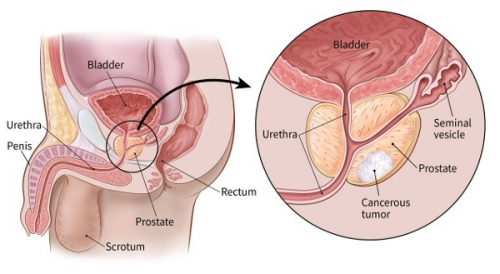

# Objective

To detect and classify the severity of prostate cancer on images of prostate tissue samples.

In practice,tissue samples are examined and scored by pathologists according to the so-called Gleason grading system which is later converted to an ISUP grade.

In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.colors
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import openslide
import skimage.io
import cv2
import fastai
from fastai.vision import *

from IPython.display import Image, display

# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go
import os
import torch
import matplotlib.pyplot as plt
from fastai.metrics import KappaScore
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F

bs = 2
N = 12
nworkers = 2


In [2]:

MODELS = [f'../input/panda-starter-models/RNXT50_{i}.pth' for i in range(4)]

sz = 128

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

 # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/prostate-cancer-grade-assessment/test.csv
/kaggle/input/prostate-cancer-grade-assessment/sample_submission.csv
/kaggle/input/prostate-cancer-grade-assessment/train.csv
/kaggle/input/prostate-cancer-grade-assessment/train_images/6d1a11077fe4183a4109d649cf319923.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/8809e1cb2640ba1c6ebf7fb3c72dc250.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/38b53a819b584debd748e16db8b2c488.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/d238858042506302cfc15c63db81341b.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/77d2d284e6b6962f2761d1d37797c465.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/d0cb73c9ad19c13c6fe93cc2c61cc073.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/d4f15bf1d630b5c3eaf6c4928ea99715.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/4b77f015acc40c7e39470f3ebb658818.tiff
/kaggle/input/prostate-cancer-grad

In [4]:
BASE_PATH='../input/prostate-cancer-grade-assessment/'
DATA = BASE_PATH+'test_images'
SAMPLE = BASE_PATH+'sample_submission.csv'
TRAIN=BASE_PATH+'train.csv'
TEST = BASE_PATH+'test.csv'

In [5]:
sys.path.insert( 0,'../input/semisupervised-imagenet-models/semi-supervised-ImageNet1K-models-master/')
from hubconf import *

In [6]:
# image and mask directories
data_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'

In [7]:
# Location of training labels
train = pd.read_csv(f'{BASE_PATH}/train.csv')
test = pd.read_csv(f'{BASE_PATH}/test.csv')
submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

In [8]:

display(train.head())
display(train.shape)

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


(10616, 4)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 4 columns):
image_id         10616 non-null object
data_provider    10616 non-null object
isup_grade       10616 non-null int64
gleason_score    10616 non-null object
dtypes: int64(1), object(3)
memory usage: 331.9+ KB


In [10]:
train.data_provider.unique()

array(['karolinska', 'radboud'], dtype=object)

In [11]:
display(len(train.data_provider.unique()))

2

In [12]:

display(test.head())
display(test.shape)
                 

,image_id,data_provider
0,005700be7e06878e6605e7a5a39de1b2,radboud
1,005c6e8877caf724c600fdce5d417d40,karolinska
2,0104f76634ff89bfff1ef0804a95c380,radboud


(3, 2)

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
image_id         3 non-null object
data_provider    3 non-null object
dtypes: object(2)
memory usage: 176.0+ bytes


In [14]:
train_image_list=os.listdir(os.path.join(BASE_PATH,'train_images'))
train_label_masks_list=os.listdir(os.path.join(BASE_PATH,'train_label_masks'))

In [15]:
train_image_list

['6d1a11077fe4183a4109d649cf319923.tiff',
 '8809e1cb2640ba1c6ebf7fb3c72dc250.tiff',
 '38b53a819b584debd748e16db8b2c488.tiff',
 'd238858042506302cfc15c63db81341b.tiff',
 '77d2d284e6b6962f2761d1d37797c465.tiff',
 'd0cb73c9ad19c13c6fe93cc2c61cc073.tiff',
 'd4f15bf1d630b5c3eaf6c4928ea99715.tiff',
 '4b77f015acc40c7e39470f3ebb658818.tiff',
 'd2029423ffecf93f8114770e5d061027.tiff',
 'a72727c39add8982af8cc5b32822bb40.tiff',
 '4621bcbbece53892b356cd1d7ca6d884.tiff',
 '92830b819eb02be8d93a9e8e8b5ae090.tiff',
 '7812bf8e4dbb7288800509b89776da73.tiff',
 'b770d7a72514c3f30684c4e632580b6e.tiff',
 'ee84768fd0b939e9fc7369652cba4a35.tiff',
 '77db80dce3763d46aacb3e82c59bc325.tiff',
 'd72dce85f1954fe33809659f9cd14217.tiff',
 '8c5fd47e838f44848c14076f71fe0d10.tiff',
 'afeae451e576086d10c45a41545f7212.tiff',
 '0032bfa835ce0f43a92ae0bbab6871cb.tiff',
 'dfb8f57174971abbab14ad065b36769b.tiff',
 '01642d24ac5520681d6a20f6c42dc4fe.tiff',
 'fc8bbe93363ee983d99c949f41ea180f.tiff',
 '071adc8288cc111233b74980684c3552

In [16]:
print(f"train image_id list:{train.image_id.nunique()}")

train image_id list:10616


In [17]:

print(f"train image list:{len(train_image_list)}")
print(f"train label masks list:{len(train_label_masks_list)}")

train image list:10616
train label masks list:10516


In [18]:
print(f"sample of image_id list:{train.image_id.values[0:3]}")
print(f"sample of image list:{train_image_list[0:3]}")
print(f"sample of label masks list:{train_label_masks_list[0:3]}")

sample of image_id list:['0005f7aaab2800f6170c399693a96917' '000920ad0b612851f8e01bcc880d9b3d' '0018ae58b01bdadc8e347995b69f99aa']
sample of image list:['6d1a11077fe4183a4109d649cf319923.tiff', '8809e1cb2640ba1c6ebf7fb3c72dc250.tiff', '38b53a819b584debd748e16db8b2c488.tiff']
sample of label masks list:['f0d3a67702abc214a7ca6c1158e5a62c_mask.tiff', '85b43e64b68fce39237fcfaf32d5a7d7_mask.tiff', '1975c20bde8ee4ef2fe32b7a3a7b3656_mask.tiff']


In [19]:
trimmed_image_list=[]
for img in train_image_list:
    trimmed_image_list.append(img.split('.tiff')[0])

In [20]:
trimmed_label_masks_list=[]
for img in train_label_masks_list:
    trimmed_label_masks_list.append(img.split('_mask.tiff')[0])

In [21]:
intersect_i_m=(set(trimmed_image_list) & set(trimmed_label_masks_list))
intersect_id_m=(set(train.image_id.unique()) & set(trimmed_label_masks_list))
intersect_id_i=(set(train.image_id.unique()) & set(trimmed_image_list))
print(f"image(tiff) & label masks:{len(intersect_i_m)}")
print(f"image_id(train) & label masks:{len(intersect_id_m)}")
print(f"image_id(train) & image(tiff):{len(intersect_id_i)}")

image(tiff) & label masks:10516
image_id(train) & label masks:10516
image_id(train) & image(tiff):10616


In [22]:
missing_masks=np.setdiff1d(trimmed_image_list,trimmed_label_masks_list)
print(f'missing masks:{len(missing_masks)} images(press output button to see the list)')

missing masks:100 images(press output button to see the list)


In [23]:
print(list(missing_masks))

['040b2c98538ec7ead1cbd6daacdb3f64', '05f2ae45ead3e5737d102656366752df', '0cbadddd6fd3eca47c33e48752f680cd', '0ebea13245a2b04ca3e6a482091e35d6', '11641ccf5569bc94de323bb50b7fec7e', '13ab419e772cf0dd8140f34f905bd918', '13aba34105b637fcf77e4efdc4ccaef4', '148b753bb4a61f27bc4f17c6d123e1ec', '1563523865810e5763f7f1dd1a30da85', '1a14633255dc8b2dd5a36fd6f3eaf839', '1aff7ddcd1864b0e2fa4fdf61e965a83', '2ac36a2e35654c0be9e818f9f9407807', '2d7eef10a777361cd0872f70dda344ba', '2f178956e9fc7df485c50395b9664b40', '31fd11d1920dede9f0fa0dcb35baa34e', '33105f777ddf03e095ed3350179b41da', '34b9896eebff5d0501dc23156b26f2b3', '3756141b86ca5f2afcacf5113d4e8f83', '3ac1b4146a8bea81e2ff2b1f2c0bb0c8', '3ae66332c2dd50c6ce458937d49f8232', '3ec8cdd4bcb971eea9c54d7dd1a49e1c', '41bfc11a16555808e8ddf2af836e6943', '458b3e1c2f1f56179d89fec4d56bd8d6', '4da79675b490fd611075cd6b84b83adb', '4e3f861386c391790eea8f0de4ab5015', '5037b3b05aec2c96a034ce9301a43326', '53f2d7fc3b642a8b6cc2d2780f6bb48b', '5477d1fe122c0b899b4be1634d

In [24]:
sub=pd.read_csv(SAMPLE)
sub.head()

,image_id,isup_grade
0,005700be7e06878e6605e7a5a39de1b2,0
1,005c6e8877caf724c600fdce5d417d40,0
2,0104f76634ff89bfff1ef0804a95c380,0


In [25]:
masks=os.listdir(BASE_PATH+'train_label_masks/')
images=os.listdir(BASE_PATH+'train_images/')
df_masks=pd.Series(masks).to_frame()
df_masks.columns=['mask_file_name']
df_masks['image_id']=df_masks.mask_file_name.apply(lambda x:x.split('_')[0])
df_train=pd.merge(train,df_masks,on='image_id',how='outer')
del df_masks

# Overview

At first glance,we found 100 images without masks.For further analysis,we will drop the 100 images without a mask.

it might be good idea to use these test cases for validation.All suspicious test cases found in this EDA are summarized in a .csv file 

# EDA

In [26]:
import seaborn as sns
def plot_count(df,feature,title='',size=2):
    f,ax=plt.subplots(1,1,figsize=(3*size,2*size))
    total=float(len(df))
    sns.countplot(df[feature],order=df[feature].value_counts().index,palette='Set3')
    plt.title(title)
    for p in ax.patches:
        height=p.get_height()
        ax.text(p.get_x()+p.get_width()/2,height+3,'{:1.2f}%'.format(100*height/total),ha="center")
    plt.show()

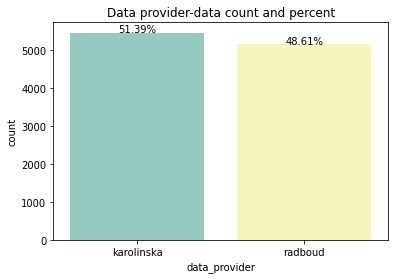

In [27]:
plot_count(train,'data_provider','Data provider-data count and percent')

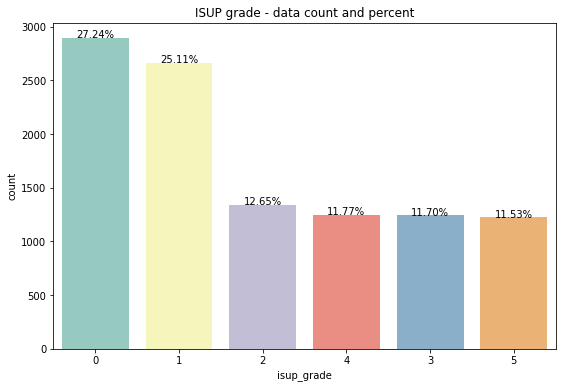

In [28]:
plot_count(train,'isup_grade','ISUP grade - data count and percent',size=3)

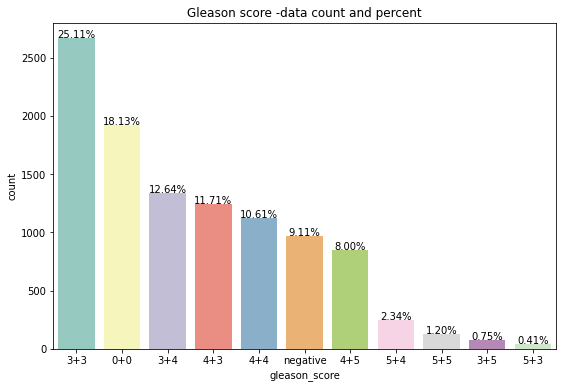

In [29]:
plot_count(train,'gleason_score','Gleason score -data count and percent',size=3)

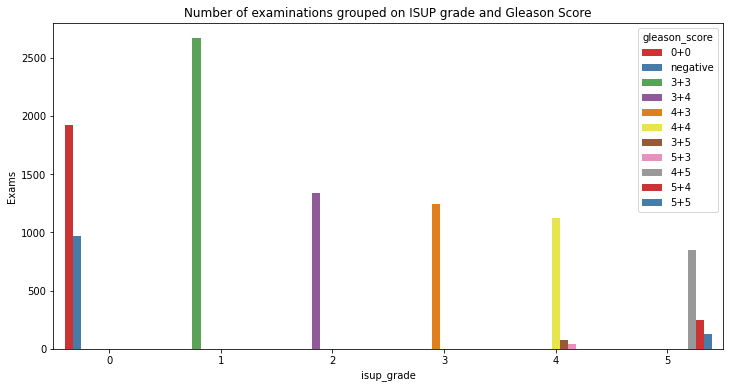

In [30]:
fig,ax=plt.subplots(nrows=1,figsize=(12,6))
tmp=train.groupby('isup_grade')['gleason_score'].value_counts()
df=pd.DataFrame(data={'Exams':tmp.values},index=tmp.index).reset_index()
sns.barplot(ax=ax,x='isup_grade',y='Exams',hue='gleason_score',data=df,palette='Set1')
plt.title("Number of examinations grouped on ISUP grade and Gleason Score")
plt.show()

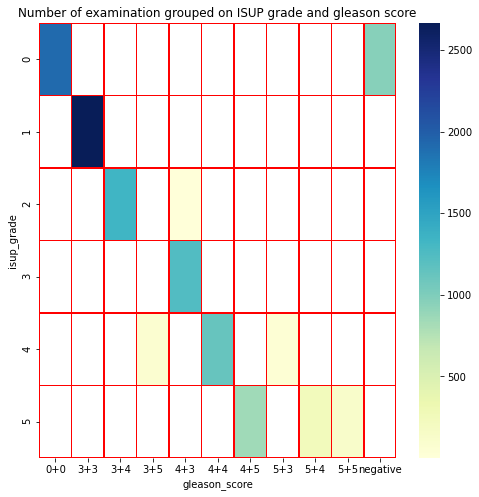

In [31]:
fig,ax=plt.subplots(nrows=1,figsize=(8,8))
heatmap_data=pd.pivot_table(df,values='Exams',index=['isup_grade'],columns='gleason_score')
sns.heatmap(heatmap_data,cmap='YlGnBu',linewidth=0.5,linecolor='Red')
plt.title('Number of examination grouped on ISUP grade and gleason score')
plt.show()

# Gleason Score and ISUP Grade

The grading process consists of finding and classifying cancer tissue into so-called Gleaon patterns(3,4, or 5).After the biopsy is assigned a Gleason score,it is converted into an ISUP grade on 1-5 scale.However,the system suffers from significant inter-observer variability between pathologists,limiting its usefulness for individual patients.

In [32]:
from IPython.display import HTML, display

data = [["Gleason Score", "ISUP Grade"],
        ["0+0", "0"], ["negative", "0"],
        ["3+3", "1"], ["3+4", "2"], ["4+3", "3"], 
        ["4+4", "4"], ["3+5", "4"], ["5+3", "4"],
        ["4+5", "5"], ["5+4", "5"], ["5+5", "5"],
        ]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
      )
))


Gleason Score,ISUP Grade
0+0,0
negative,0
3+3,1
3+4,2
4+3,3
4+4,4
3+5,4
5+3,4
4+5,5
5+4,5


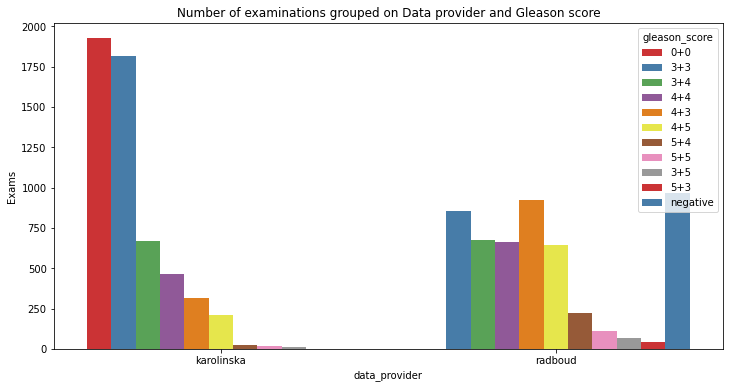

In [33]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6)) 
tmp = train.groupby('data_provider')['gleason_score'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'data_provider', y='Exams',hue='gleason_score',data=df, palette='Set1') 
plt.title("Number of examinations grouped on Data provider and Gleason score") 
plt.show()

**One Mislabeled Image?**

In the above dataframe it looks like one image might have been converted to wrong ISUP grade.

In [34]:
df_train[(df_train.isup_grade==2)&(df_train.gleason_score !='3+4')]

,image_id,data_provider,isup_grade,gleason_score,mask_file_name
7273,b0a92a74cb53899311acc30b7405e101,karolinska,2,4+3,b0a92a74cb53899311acc30b7405e101_mask.tiff


All the Karolinska images in the training data is graded by the same pathologist.However,for the test set we used several pathologists who each labeled the images using ISUP(not Gleason) and derived a consensus label.The mislabeled image was one of the those images but was later moved to the training set. 

# Differences Between Data Providers

They used different scanners with slightly different maximu  microscope resolutions and worked with different pathologists for labeling their images.

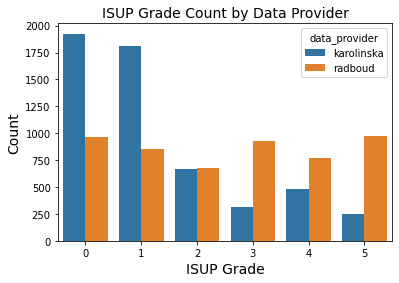

In [35]:
data_providers=df_train.data_provider.unique()
fig=plt.figure(figsize=(6,4))
ax=sns.countplot(x="isup_grade",hue="data_provider",data=df_train)
plt.title("ISUP Grade Count by Data Provider",fontsize=14)
plt.xlabel("ISUP Grade",fontsize=14)
plt.ylabel("Count",Fontsize=14)
plt.show()

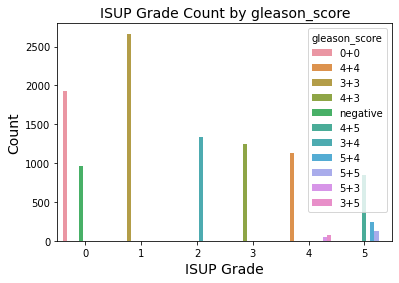

In [36]:
data_providers=df_train.gleason_score.unique()
fig=plt.figure(figsize=(6,4))
ax=sns.countplot(x="isup_grade",hue="gleason_score",data=df_train)
plt.title("ISUP Grade Count by gleason_score",fontsize=14)
plt.xlabel("ISUP Grade",fontsize=14)
plt.ylabel("Count",Fontsize=14)
plt.show()

In [37]:
def plot_relative_distribution(df, feature, hue, title='', size=2):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    total = float(len(df))
    sns.countplot(x=feature, hue=hue, data=df, palette='Set2')
    plt.title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

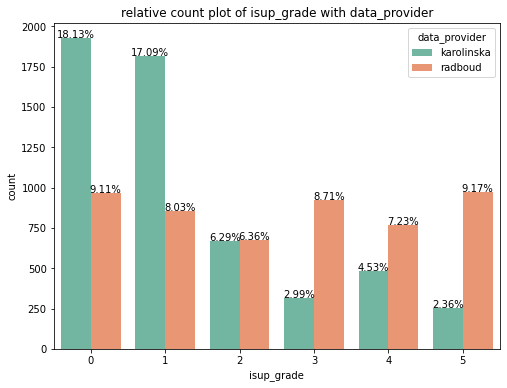

In [38]:
plot_relative_distribution(df=train, feature='isup_grade', hue='data_provider', title = 'relative count plot of isup_grade with data_provider', size=2)


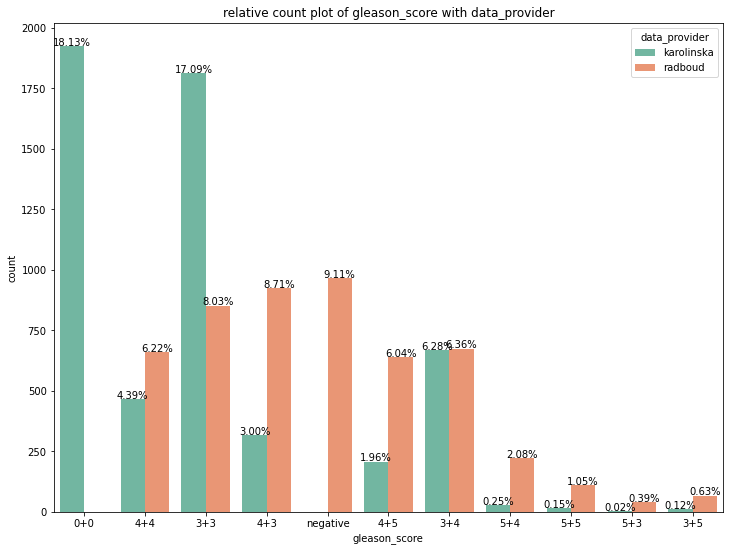

In [39]:
plot_relative_distribution(df=train, feature='gleason_score', hue='data_provider', title = 'relative count plot of gleason_score with data_provider', size=3)

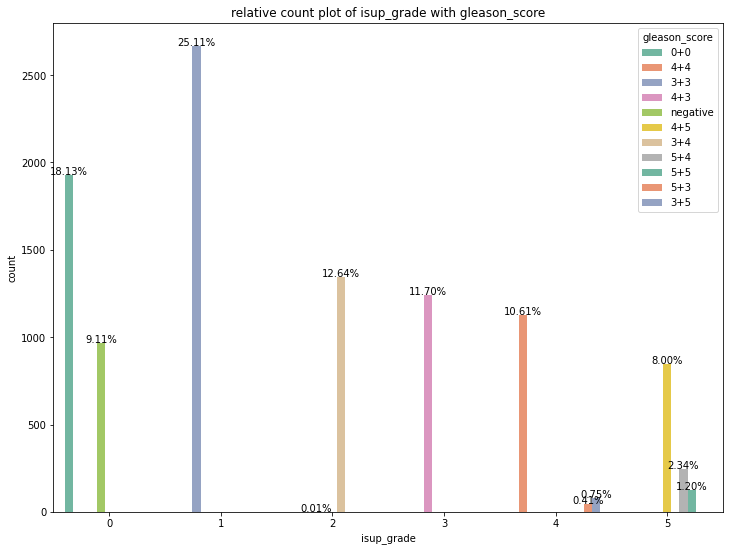

In [40]:
plot_relative_distribution(df=train, feature='isup_grade', hue='gleason_score', title = 'relative count plot of isup_grade with gleason_score', size=3)

# Visualizing Image and Mask Samples

Let's have a quick first look at the differences between the data providers in regards to the original images and the masks.

**Radboud:**Prostate glands are individually labelled.Valid values are:
* 0:background (non tissue) or unknown
* 1:stroma(connective tissue,non-epithelium tissue)
* 2.healthy (benign) epithelium
* 3.cancerous epithelium (Gleason 3)
* 4.Cancerous epithelium (Gleason 4)
* 5.Cancerous epithelium (Gleason 5)

**Karolinska**:Regions are labelled.Valid values are:
* [0]:backgound (non tissue) or unknown
* [1]:benign tissue(stroma and epithelium combined)
* [2]:cancerous tissue (stroma and epithelium combined)

In [41]:
def display_images(slides): 
    f, ax = plt.subplots(5,3, figsize=(18,22))
    for i, slide in enumerate(slides):
        image = openslide.OpenSlide(os.path.join(data_dir, f'{slide}.tiff'))
        spacing = 1 / (float(image.properties['tiff.XResolution']) / 10000)
        patch = image.read_region((1780,1950), 0, (256, 256))
        ax[i//3, i%3].imshow(patch) 
        image.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = slide
        data_provider = train.loc[slide, 'data_provider']
        isup_grade = train.loc[slide, 'isup_grade']
        gleason_score = train.loc[slide, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")

    plt.show() 


In [42]:
images = ['07a7ef0ba3bb0d6564a73f4f3e1c2293','037504061b9fba71ef6e24c48c6df44d','035b1edd3d1aeeffc77ce5d248a01a53','059cbf902c5e42972587c8d17d49efed','06a0cbd8fd6320ef1aa6f19342af2e68','06eda4a6faca84e84a781fee2d5f47e1','0a4b7a7499ed55c71033cefb0765e93d','0838c82917cd9af681df249264d2769c','046b35ae95374bfb48cdca8d7c83233f','074c3e01525681a275a42282cd21cbde',
'05abe25c883d508ecc15b6e857e59f32','05f4e9415af9fdabc19109c980daf5ad','060121a06476ef401d8a21d6567dee6d','068b0e3be4c35ea983f77accf8351cc8','08f055372c7b8a7e1df97c6586542ac8'
]



KeyError: '07a7ef0ba3bb0d6564a73f4f3e1c2293'

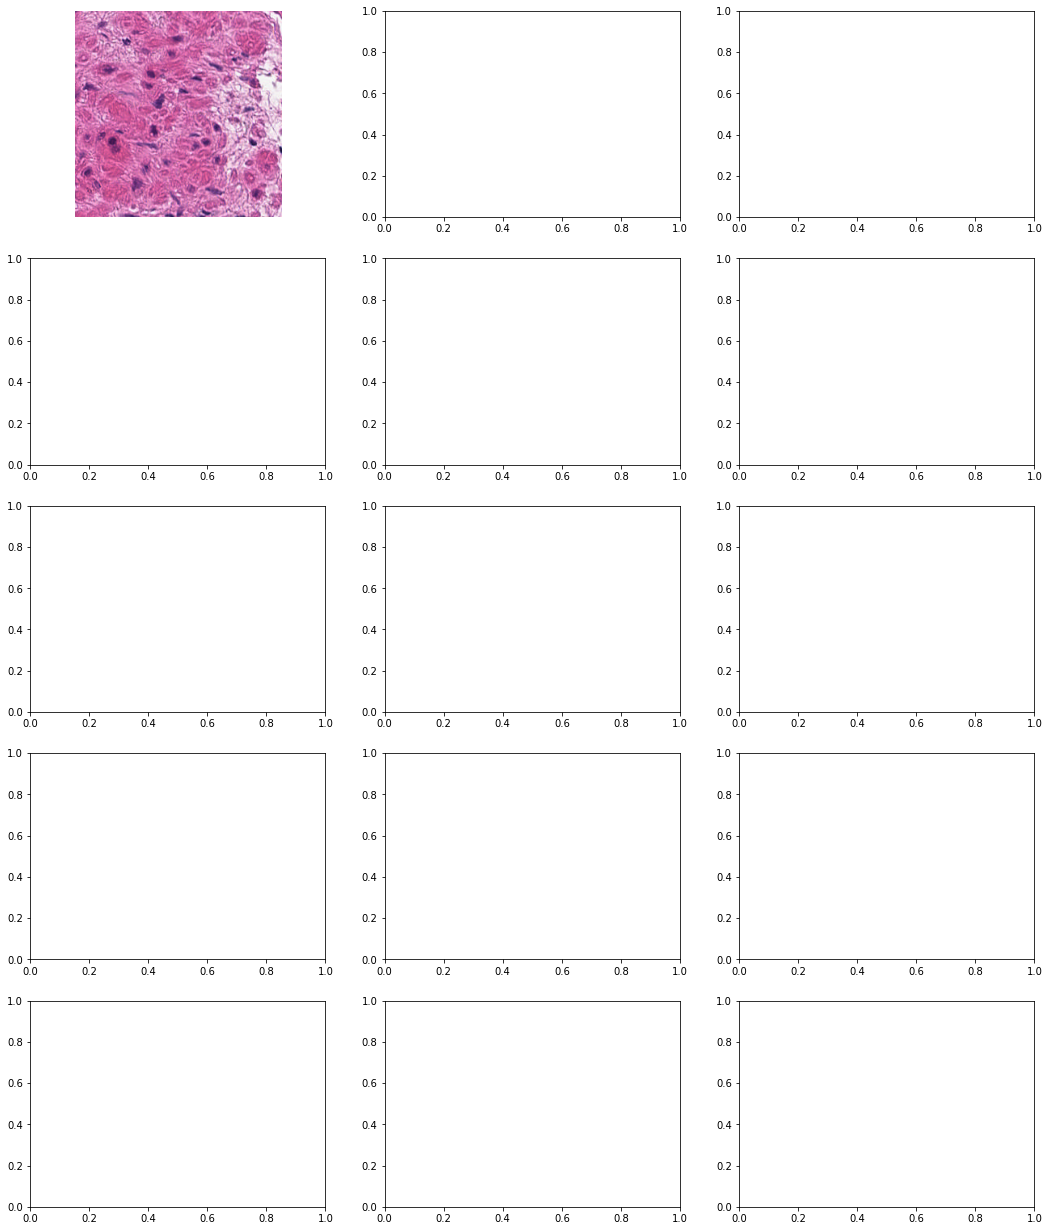

In [43]:
display_images(images)

In [44]:
def display_masks(slides): 
    f, ax = plt.subplots(5,3, figsize=(18,22))
    for i, slide in enumerate(slides):
        
        mask = openslide.OpenSlide(os.path.join(mask_dir))
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
        cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

        ax[i//3, i%3].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) 
        mask.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = slide
        data_provider = train.loc[slide, 'data_provider']
        isup_grade = train.loc[slide, 'isup_grade']
        gleason_score = train.loc[slide, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")
        f.tight_layout()
        
    plt.show()


In [45]:
display_masks(data_sample)

NameError: name 'data_sample' is not defined

In [46]:
data_providers = ['karolinska', 'radboud']
train_df = pd.read_csv(f'{BASE_PATH}/train.csv')
masks = os.listdir(mask_dir)
masks_df = pd.Series(masks).to_frame()
masks_df.columns = ['mask_file_name']
masks_df['image_id'] = masks_df.mask_file_name.apply(lambda x: x.split('_')[0])
train_df = pd.merge(train_df, masks_df, on='image_id', how='outer')
del masks_df
print(f"There are {len(train_df[train_df.mask_file_name.isna()])} images without a mask.")

## removing items where image mask is null
train_df = train_df[~train_df.mask_file_name.isna()]

There are 100 images without a mask.


In [47]:
display_masks(data_sample)


NameError: name 'data_sample' is not defined

few images and associated masks for samples with Gleason Score(5+5)

In [48]:
sample_images = list(train.loc[train.gleason_score=="5+5", "image_id"])
sample_images = [ '08459aaedfda0679aab403ababbd6ece','0a848ccbbb065ef5ee59dd01710f8531', '0bbbb6734f721f4df4d2ba60ade0ed15', 
                 '0bd231c85b2695e2cf021299e67a6afc',  '0efdb66c93d6b474d93dfe41e40be6ca', '1364c10e1e7f1ad0457f649a44d74888', 
                 '1e644a98460e4f7ea50717720a001efd',  '1fb65315d7ded63d688194863a1b123e', '244d9617bd58fa1db73ab4c1f40d298e']
data_sample = train.loc[train.image_id.isin(sample_images)]
show_images(data_sample)


NameError: name 'show_images' is not defined

In [49]:
def load_and_resize_image(img_id):
    """
    Edited from https://www.kaggle.com/xhlulu/panda-resize-and-save-train-data
    """
    biopsy = skimage.io.MultiImage(os.path.join(data_dir, f'{img_id}.tiff'))
    return cv2.resize(biopsy[-1], (512, 512))

def load_and_resize_mask(img_id):
    """
    Edited from https://www.kaggle.com/xhlulu/panda-resize-and-save-train-data
    """
    biopsy = skimage.io.MultiImage(os.path.join(mask_dir, f'{img_id}_mask.tiff'))
    return cv2.resize(biopsy[-1], (512, 512))[:,:,0]

KeyError: '0005f7aaab2800f6170c399693a96917'

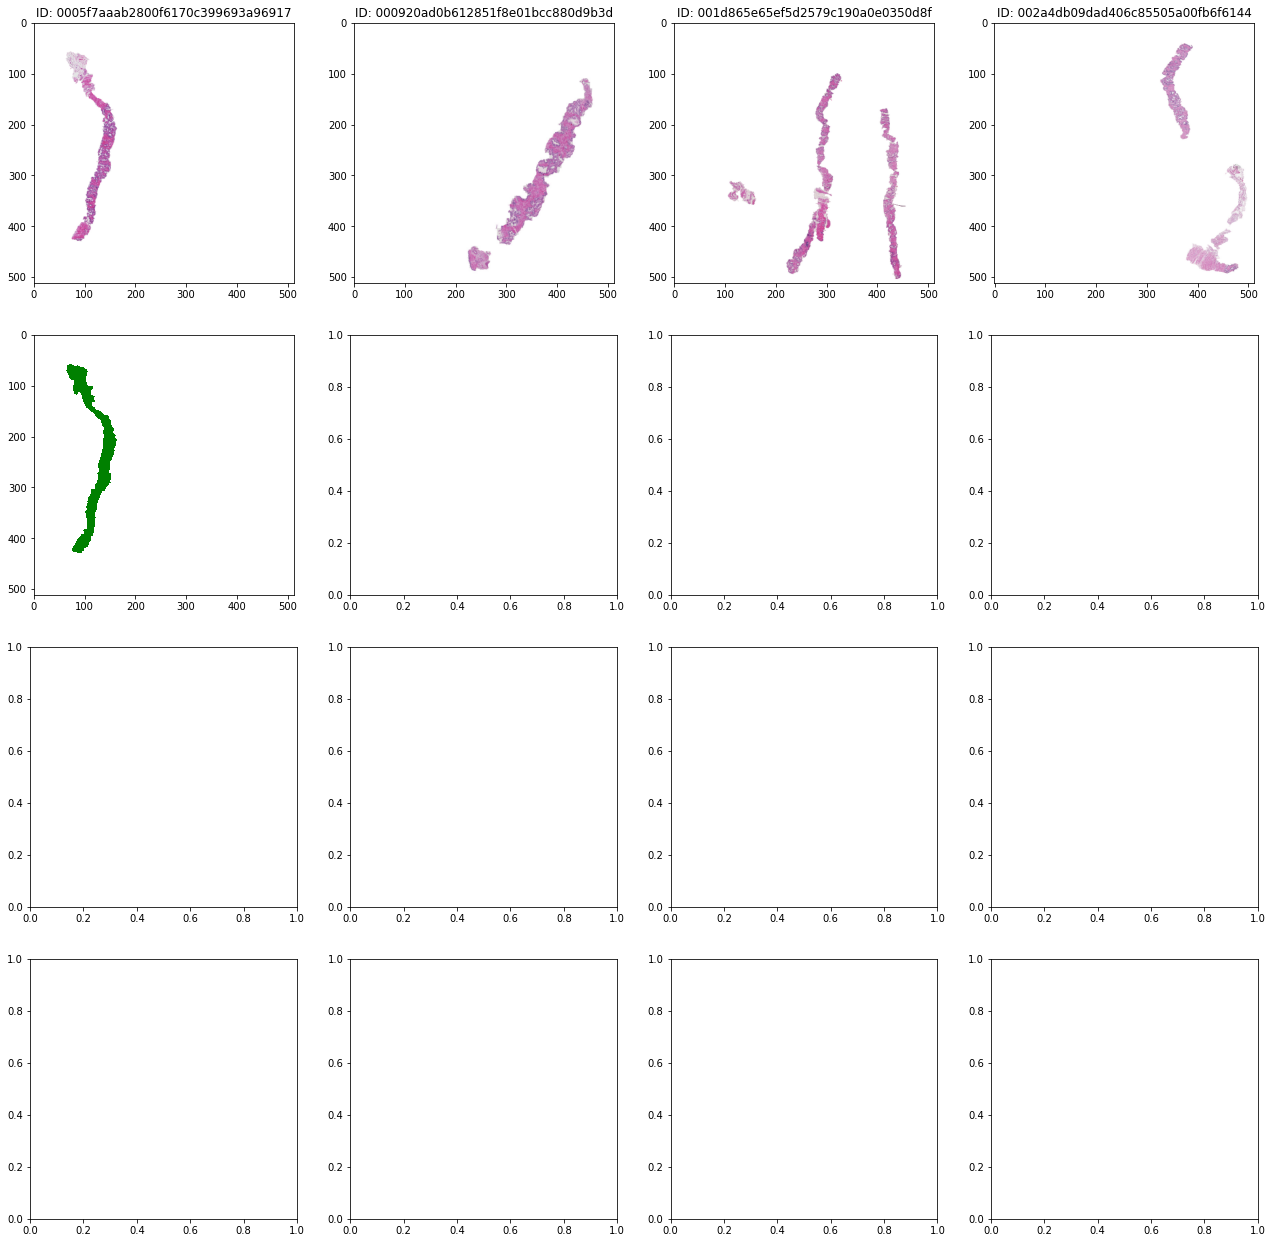

In [50]:

labels = []
for grade in range(train.isup_grade.nunique()):
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(22, 22))

    for i, row in enumerate(ax):
        idx = i//2
        temp = train_df[(train_df.isup_grade == grade) & (train_df.data_provider == data_providers[idx])].image_id.head(4).reset_index(drop=True)
        if i%2 < 1:
            labels.append(f'{data_providers[idx]} (image)')
            for j, col in enumerate(row):
                col.imshow(load_and_resize_image(temp[j]))
                col.set_title(f"ID: {temp[j]}")
                
        else:
            labels.append(f'{data_providers[idx]} (mask)')
            for j, col in enumerate(row):
                if data_providers[idx] == 'radboud':
                    col.imshow(load_and_resize_mask(temp[j]), 
                               cmap = matplotlib.colors.ListedColormap(['white', 'lightgrey', 'green', 'orange', 'red', 'darkred']), 
                               norm = matplotlib.colors.Normalize(vmin=0, vmax=5, clip=True))
                else:
                    col.imshow(load_and_resize_mask(temp[j]), 
                           cmap = matplotlib.colors.ListedColormap(['white', 'green', 'red']), 
                           norm = matplotlib.colors.Normalize(vmin=0, vmax=2, clip=True))
                    
                gleason_score = train.loc[temp[j], 'gleason_score']
                col.set_title(f"ID: {temp[j]}")
        
    for row, r in zip(ax[:,0], labels):
        row.set_ylabel(r, rotation=90, size='large', fontsize=14)

    plt.suptitle(f'ISUP Grade {grade}', fontsize=20)
    plt.show()

Parse all images for train data to extract image characteristics

# **Overlaying masks on the slides**

As the masks have the same dimension as the slides ,we can overlay the masks on the tissue to directly see which areas are cancerous .This overlay can help you identifying the different growth patterns.To do this,we load both the mask and the biopsy and merge them using PIL. 

In [51]:
def overlay_mask_on_slide(images, center='radboud', alpha=0.8, max_size=(800, 800)):
    """Show a mask overlayed on a slide."""
    f, ax = plt.subplots(5,3, figsize=(18,22))
    
    
    for i, image_id in enumerate(images):
        slide = openslide.OpenSlide(os.path.join(data_dir, f'{image_id}.tiff'))
        mask = openslide.OpenSlide(os.path.join(mask_dir, f'{image_id}_mask.tiff'))
        slide_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
        mask_data = mask_data.split()[0]
        
        
        # Create alpha mask
        alpha_int = int(round(255*alpha))
        if center == 'radboud':
            alpha_content = np.less(mask_data.split()[0], 2).astype('uint8') * alpha_int + (255 - alpha_int)
        elif center == 'karolinska':
            alpha_content = np.less(mask_data.split()[0], 1).astype('uint8') * alpha_int + (255 - alpha_int)

        alpha_content = PIL.Image.fromarray(alpha_content)
        preview_palette = np.zeros(shape=768, dtype=int)

        if center == 'radboud':
            # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
            preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
        elif center == 'karolinska':
            # Mapping: {0: background, 1: benign, 2: cancer}
            preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)

        mask_data.putpalette(data=preview_palette.tolist())
        mask_rgb = mask_data.convert(mode='RGB')
        overlayed_image = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
        overlayed_image.thumbnail(size=max_size, resample=0)

        
        ax[i//3, i%3].imshow(overlayed_image) 
        slide.close()
        mask.close()       
        ax[i//3, i%3].axis('off')
        
        data_provider = train.loc[image_id, 'data_provider']
        isup_grade = train.loc[image_id, 'isup_grade']
        gleason_score = train.loc[image_id, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")


KeyError: '07a7ef0ba3bb0d6564a73f4f3e1c2293'

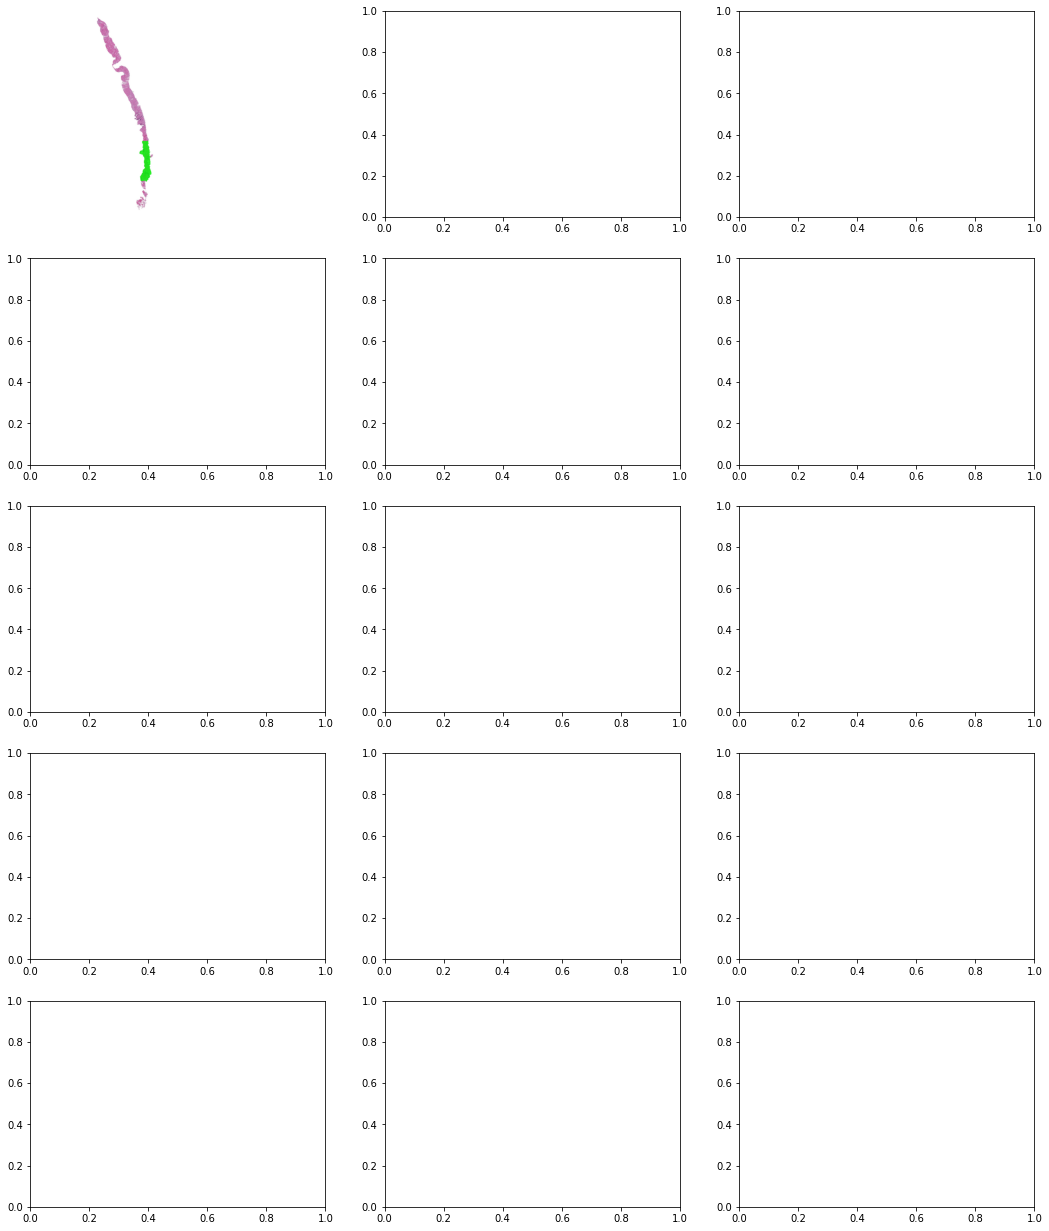

In [52]:
overlay_mask_on_slide(images)

#  Expolring images with pen markers

It is mentioned that in training dataset,there are few images with pen markers on them.The organizers left us with a Note as described below.
Note:that slightly different procedures were in place for the images used in the test set than training set.Some of the training set images have stray pen marks on them,but the test slides are free of pen marks.

KeyError: '07a7ef0ba3bb0d6564a73f4f3e1c2293'

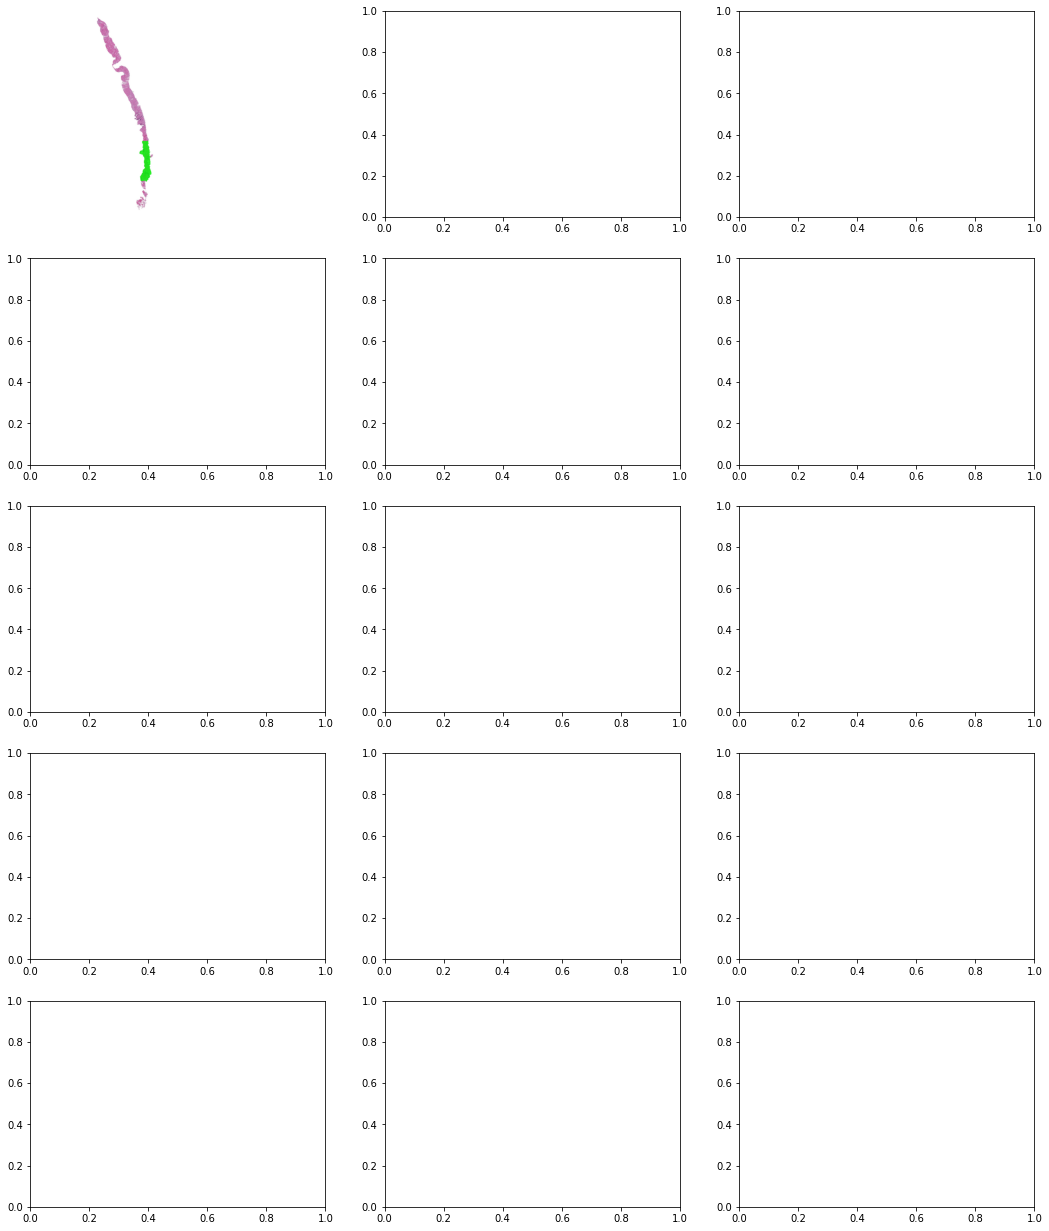

In [53]:
overlay_mask_on_slide(images)

In [54]:
pen_marked_images = [
    
    'ebb6a080d72e09f6481721ef9f88c472',
    'ebb6d5ca45942536f78beb451ee43cc4',
    'ea9d52d65500acc9b9d89eb6b82cdcdf',
    'e726a8eac36c3d91c3c4f9edba8ba713',
    'e90abe191f61b6fed6d6781c8305fe4b',
    'fd0bb45eba479a7f7d953f41d574bf9f',
    'ff10f937c3d52eff6ad4dd733f2bc3ac',
    'feee2e895355a921f2b75b54debad328',
    'feac91652a1c5accff08217d19116f1c',
    'fb01a0a69517bb47d7f4699b6217f69d',
    'f00ec753b5618cfb30519db0947fe724',
    'e9a4f528b33479412ee019e155e1a197',
    'f062f6c1128e0e9d51a76747d9018849',
    'f39bf22d9a2f313425ee201932bac91a',
]

KeyError: 'ebb6a080d72e09f6481721ef9f88c472'

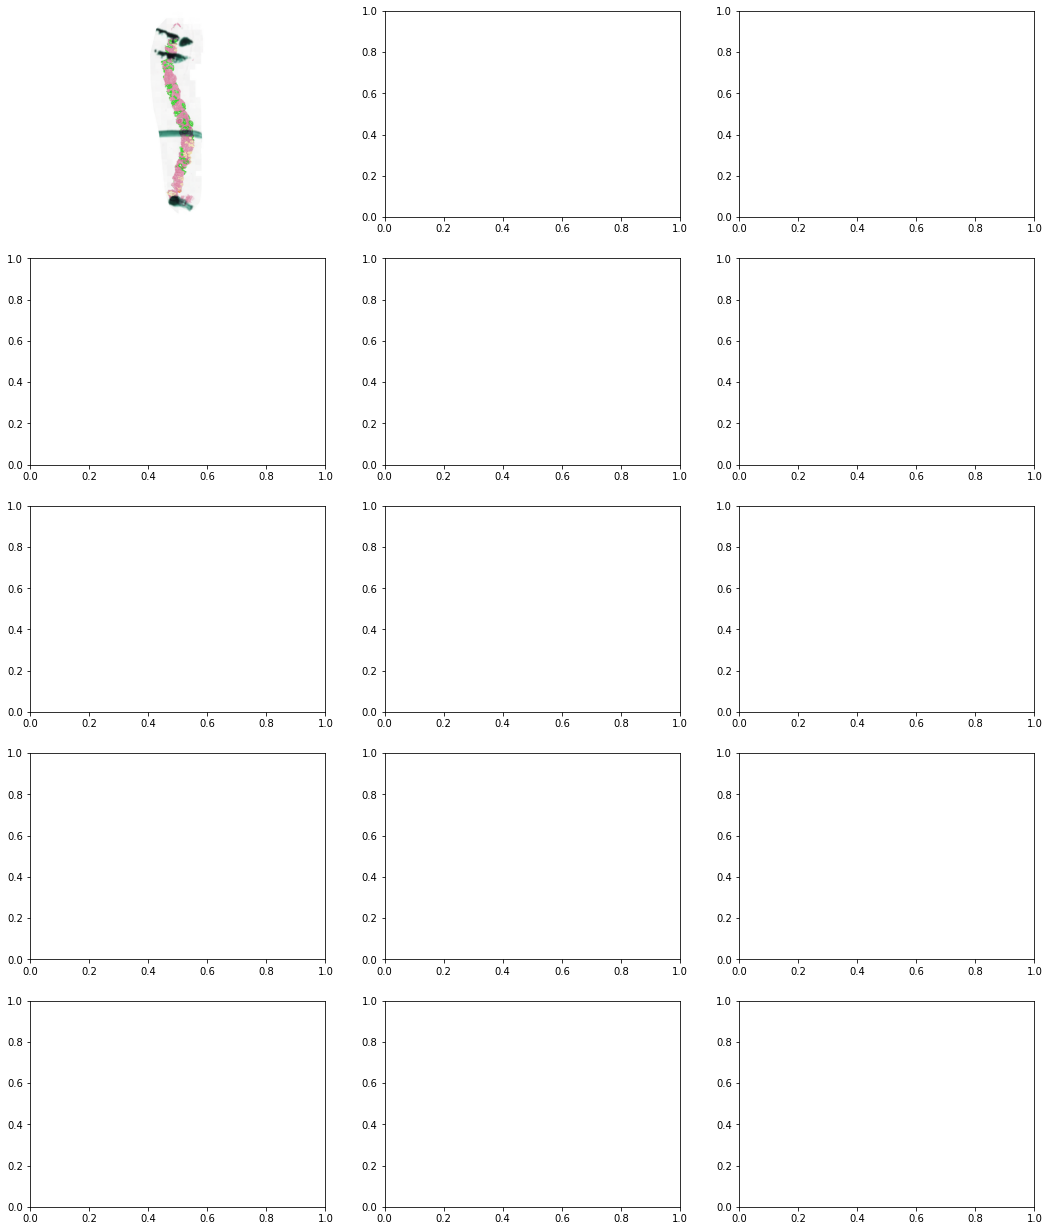

In [55]:
overlay_mask_on_slide(pen_marked_images)

In [56]:
import time
start_time = time.time()
slide_dimensions, spacings, level_counts = [], [], []

for image_id in train.image_id:
    image = str(image_id)+'.tiff'
    image_path = os.path.join(PATH,"train_images",image)
    slide = openslide.OpenSlide(image_path)
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    slide_dimensions.append(slide.dimensions)
    spacings.append(spacing)
    level_counts.append(slide.level_count)
    slide.close()
    del slide

train['width']  = [i[0] for i in slide_dimensions]
train['height'] = [i[1] for i in slide_dimensions]
train['spacing'] = spacings
train['level_count'] = level_counts

end_time = time.time()
print(f"Total processing time: {round(end_time - start_time,2)} sec.")

NameError: name 'PATH' is not defined

# Model

In [57]:


class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)


In [58]:
def _resnext(url,block,layers,pretrained,progress,**kwargs):
    model=ResNet(block,layers,**kwargs)
    return model
class Model(nn.Module):
    def __init__(self,arch='resnext50_32x4d',n=6,pre=True):
        super().__init__()
        m=_resnext(semi_supervised_model_urls[arch],Bottleneck,[3,4,6,3],False,progress=False,groups=32,width_per_group=4)
        self.enc=nn.Sequential(*list(m.children())[:-2])
        nc=list(m.children())[-1].in_features
        self.head = nn.Sequential(AdaptiveConcatPool2d(),Flatten(),nn.Linear(2*nc,512),
                Mish(),nn.BatchNorm1d(512),nn.Dropout(0.5),nn.Linear(512,n))
        
    def forward(self, x):
        shape = x.shape
        n = shape[1]
        x = x.view(-1,shape[2],shape[3],shape[4])
        x = self.enc(x)
        shape = x.shape
        x = x.view(-1,n,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
          .view(-1,shape[1],shape[2]*n,shape[3])
        x = self.head(x)
        return x
models = []

In [59]:
models = []
for path in MODELS:
    state_dict = torch.load(path,map_location=torch.device('cpu'))
    model = Model()
    model.load_state_dict(state_dict)
    model.float()
    model.eval()
    model.cuda()
    models.append(model)

In [60]:
del state_dict

In [61]:
def tile(img):
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                 constant_values=255)
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    if len(img) < N:
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    return img

mean = torch.tensor([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])
std = torch.tensor([0.36357649, 0.49984502, 0.40477625])

class PandaDataset(Dataset):
    def __init__(self, path, test):
        self.path = path
        self.names = list(pd.read_csv(test).image_id)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        img = skimage.io.MultiImage(os.path.join(DATA,name+'.tiff'))[-1]
        tiles = torch.Tensor(1.0 - tile(img)/255.0)
        tiles = (tiles - mean)/std
        return tiles.permute(0,3,1,2), name

# Prediction

In [62]:
sub_df = pd.read_csv(SAMPLE)
if os.path.exists(DATA):
    ds = PandaDataset(DATA,TEST)
    dl = DataLoader(ds, batch_size=bs, num_workers=nworkers, shuffle=False)
    names,preds = [],[]

    with torch.no_grad():
        for x,y in tqdm(dl):
            x = x.cuda()
            #dihedral TTA
            x = torch.stack([x,x.flip(-1),x.flip(-2),x.flip(-1,-2),
              x.transpose(-1,-2),x.transpose(-1,-2).flip(-1),
              x.transpose(-1,-2).flip(-2),x.transpose(-1,-2).flip(-1,-2)],1)
            x = x.view(-1,N,3,sz,sz)
            p = [model(x) for model in models]
            p = torch.stack(p,1)
            p = p.view(bs,8*len(models),-1).mean(1).argmax(-1).cpu()
            names.append(y)
            preds.append(p)
    
    names = np.concatenate(names)
    preds = torch.cat(preds).numpy()
    sub_df = pd.DataFrame({'image_id': names, 'isup_grade': preds})
    


In [63]:
sub_df.to_csv("submission.csv", index=False)
sub_df.head(5)

,image_id,isup_grade
0,005700be7e06878e6605e7a5a39de1b2,0
1,005c6e8877caf724c600fdce5d417d40,0
2,0104f76634ff89bfff1ef0804a95c380,0
